In [15]:
from model import atp_graph, losses
from data import synthetic_data_gen, feature_extractor
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline
from comparison_models.tnp import tnp_pipeline
from data import dataset_preparer
import argparse
from Tutorials.helper import batcher
import os

In [16]:
dataset = "weather"
model = "atp"
iterations = 300
num_repeats = 1
n_C = 100
n_T = 50

In [17]:


if dataset == "weather":
    x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.weather_processor(path_to_weather_data="datasets/weather.csv") 
    save_dir = "weights/forecasting/weather"


batch_size = 32
test_batch_s = 100

nll_list = []
mse_list = []

for i in range(num_repeats):

    step = 1
    run= 50 + i
    tf.random.set_seed(run)

    if model == "atp":
        model = atp_pipeline.instantiate_atp(dataset)

    if model == "tnp":
        model = tnp_pipeline.instantiate_tnp(dataset)

    tr_step = atp_graph.build_graph()

    ###### can we put the name of the model into the folder name #########?

    name_comp = 'run_' + str(run)
    folder = save_dir + '/ckpt/check_' + name_comp
    if not os.path.exists(folder): os.mkdir(folder)
    opt = tf.keras.optimizers.Adam(3e-4)
    ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
    manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
    ckpt.restore(manager.latest_checkpoint) 
    sum_mse_tot = 0; sum_nll_tot = 0
    mini = 50000


   



In [18]:
import matplotlib.pyplot as plt

In [19]:
array = []
train_array = []

Tensor("atp_pipeline_1/argsort/TopKV2:1", shape=(1, 50), dtype=int32)
Tensor("Const_2:0", shape=(), dtype=bool)
Tensor("atp_pipeline_1/argsort/TopKV2:1", shape=(1, 50), dtype=int32)
Tensor("Const_2:0", shape=(), dtype=bool)


2023-05-03 21:39:05.436526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(
[[47 26 10 28  9 39  1 12 31 42 45 17 34 44 43  3 21 37 38 13 49 25 35 27
  18  6  5 14 41  2 32 20 40 46 15 48 22 29 23 16  7 24 36 30 11  8  4 19
  33  0]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)


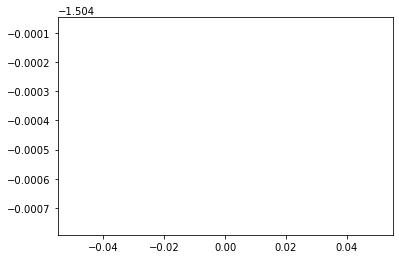

tf.Tensor(-1.5040814, shape=(), dtype=float32)
tf.Tensor(-1.5040814, shape=(), dtype=float32)


In [20]:
for i in range(50):
    idx_list = list(range(x_train.shape[0] - (n_C+n_T)))
    x,y,_ = batcher(x_train,y_train,idx_list,window=n_C+n_T) ####### generalise for not just forecasting
    _,_, nll_pp_tr, _ = tr_step(model, opt, x,y,n_C,n_T, training=True)

    if i % 100 == 0:
        train_array.append(nll_pp_tr)
        idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
        t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
        μ, log_σ = model([t_te, y_te, n_C, n_T, False])
        _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
        array.append(nll_pp_te)
        
        plt.plot(train_array)
        plt.plot(array)
        plt.show()

        print(nll_pp_te)
        print(min(array))

        if nll_pp_te < mini:
            mini = nll_pp_te
            manager.save()
            step += 1
            ckpt.step.assign_add(1)




In [21]:
ckpt = tf.train.Checkpoint(step=tf.Variable(step), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 

In [22]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))

t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)


tf.Tensor(
[[27 39 15 46 35 12 22 49 45  9 40  0 31 18  5 23 32 42 37 16 29 48 41 25
   2 26 38 17  1 47 36  7 24  6 11 44 10 19 28 20 43  3  8 33  4 21 14 30
  13 34]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)


In [23]:
nll_pp_te

<tf.Tensor: shape=(), dtype=float32, numpy=-1.6143489>

In [24]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = x_test.shape[0]//test_batch_s

In [25]:
len(idx_list)

10390

In [26]:
test_batch_s = 100

idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
num_batches = len(idx_list)//test_batch_s

for _ in range(num_batches): #### specify correct number of batches for the batcher #####
    if(_ == (num_batches-1)): test_batch_s = len(idx_list)    
    print(len(idx_list))
    print(test_batch_s)
    t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)
    μ, log_σ = model([t_te, y_te, n_C, n_T, False])
    _, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
    sum_nll_tot += sum_nll / n_T
    sum_mse_tot += sum_mse / n_T

nllx =  sum_nll_tot / (test_batch_s * x_test.shape[0]//test_batch_s)
msex =  sum_mse_tot / (test_batch_s * x_test.shape[0]//test_batch_s)


nll_list.append(nllx.numpy())
mse_list.append(msex.numpy())

#     np.save(save_dir + '/nll_list.npy', nll_list)    
#     np.save(save_dir + '/mse_list.npy', mse_list)  

10390
100
tf.Tensor(
[[45 28 38 20 33 42  6 48 39 46  9  8  2 27 40 14 16 18 15 47 35 31 41 44
   3 34 32 37  5  4 23 49 17 29 25 19 10 24 22 30 26 12 43  7 36 11 13  1
  21  0]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
10290
100
tf.Tensor(
[[41  3 40  2 24 17 42 43 35 11 14 44 45 10 47 31  8 23 32 28  4  1 26  7
  29 30 21 48 22 38 36 33  0 16  9 46 37 13  5 19 49 25 20 18 39 34 27  6
  15 12]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
10190
100
tf.Tensor(
[[20 14 33  5 13 35 15 24 17 38 47 29 36 42 44 34 39  2 30 12  0 21 27 19
   1 46 41 16 22 31  4 45 49  8  9 25 37 26 10  3 11  7 18 40 32  6 23 43
  28 48]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
10090
100
tf.Tensor(
[[25  3 17  6  7 35 40 45 48 44 12 28 10 13  1 49 42  5  9 27 31 20  2 18
  29 14 26 16 11 15 23 34 30 21 19 41 39  0 47 32 38 33 36  4 22 37  8 43
  24 46]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
9990
100
tf.

In [27]:
idx_list = list(range(x_test.shape[0] - (n_C+n_T)))
t_te,y_te,idx_list = batcher(x_test, y_test, idx_list,batch_s = test_batch_s, window=n_C+n_T)

μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
print(sum_nll/n_T/100)

tf.Tensor(
[[20 13 40 15 23 30 21 34 44 19 18  1  5  6 17 16 48  8 47 27 39 36 26 45
   7 28 25 31 35  3 29 10 43 24 49 38 11 12 46  2  0 42  9 41 33 37 14 22
   4 32]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(-3.2849836, shape=(), dtype=float32)


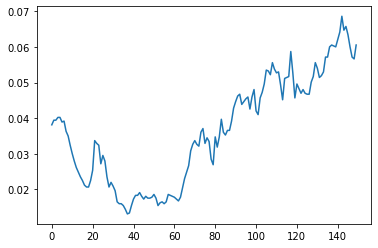

In [28]:
plt.plot(y_te[4])

In [29]:
idx_list = list(range(x_val.shape[0] - (n_C+n_T)))
t_te,y_te,_ = batcher(x_val,y_val,idx_list,batch_s = 100,window=n_C+n_T)
μ, log_σ = model([t_te, y_te, n_C, n_T, False])
_, sum_mse, sum_nll, _, _ = losses.nll(y_te[:, n_C:n_C+n_T], μ, log_σ)
print(sum_nll/n_T/100)

tf.Tensor(
[[18 32 14 24 30 37 29 22 28  8 45 39 20  0 43 46 31 17 16 19  5  6 26 44
  41 35 25 40 42 48  2 47 38 27 36  7 12  9 23 15 13 49 34  4 21  1 33 10
  11  3]], shape=(1, 50), dtype=int32)
tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(-1.5154082, shape=(), dtype=float32)


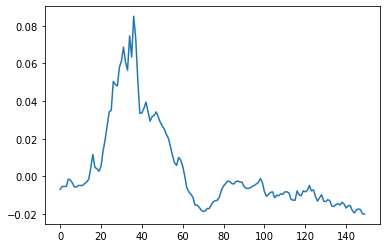

In [30]:
plt.plot(y_te[4])

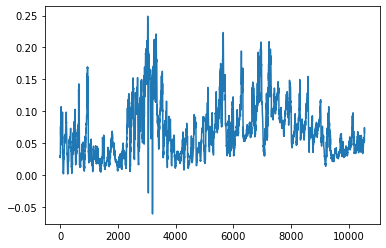

In [31]:
plt.plot(y_test[:,0,0])

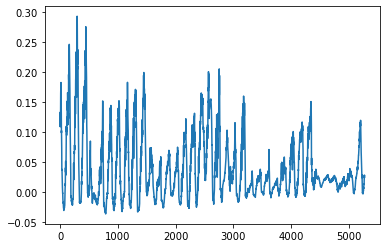

In [32]:
plt.plot(y_val[:,0,0])

In [33]:
sum_nll/n_T/100

<tf.Tensor: shape=(), dtype=float32, numpy=-1.5154082>

In [34]:
nllx

<tf.Tensor: shape=(), dtype=float32, numpy=-1.7052623>

In [35]:
msex

<tf.Tensor: shape=(), dtype=float32, numpy=0.0017760954>